## Содержание

1.
2.
3.

## Описание

Практика следующих тем:
- Парсинг
- Визуализация 
- Географическая визуализация

Предметная область данных:
- Фигурное катание

## Справка по предметной области

Современное оценивание соревнований по фигурному катанию представляет собой целый набор правил и формул для расчета итогового результата.
Каждый элемент оценивается судейской бригодой и техническими специалистами и приносит спортсмену определенную базовую стоимость (BV) и надбавки за качество (GOE).
Также отдельно оцениваются художественные "компоненты", тоже по определенным правилам. Спортсмен выступает два раза с разным набором элементов - с короткой и произвольной программой. Результат суммируется.
Такая система используется с 2004 года и называется "новой системой оценивания" или "новой системой судейства" (взамен "старой" - основаной на оценках типа "6.0")

Новая система судейства была нацелена на справедливость и снижение фактора субъективности в оценивании. При современном подходе итоговые протоколы оценивания позволяют не только выявить победителя, но и оценить вклад в его результат каждого отдельного элемента. Таким образом протоколы содержат достаточное количество данных, по которым можно собрать определенную статистику и провести некоторый анализ

Пример протокола судейства для короткой программы Ирины Слуцкой на чемпионате мира 2005 года

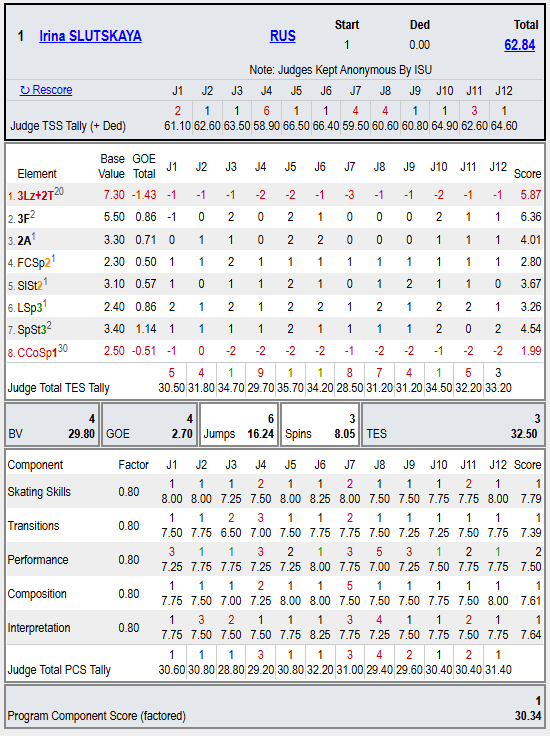


## Импорты

In [235]:
# # pip install beautifulsoup4 
# # pip install lxml
# # pip install requests
# !pip install tqdm
# pip install openpyxl --upgrade
# pip install geopandas
# !pip install matplotlib

In [236]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import time
from tqdm import tqdm
import geopandas as gpd
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

## Получение данных

В качестве источника взят сайт с официальными результатами соревнований по фигруному катанию в новой системе оценивания

Общий вид страницы выглядит следующим образом:

https://skatingscores.com/2425/wc/sr/women/i/short/usa/alysa_liu/

https://skatingscores.com/сезон/чемпионат/возрастная категория/дисциплина/i/программа/страна/участник/

Соберем информацию для чемпионатов мира за все года с новой системой оценивания в взрослом женском одиночном катании. Для этого нужно циклом пройтись по всем страницам и собрать нужные данные



In [ ]:
## Пример ссылки выглядит следующим образом: 'https://skatingscores.com/2425/wc/sr/women/i/short/'

## Нам нужно будет пройтись по всем годам
### Года указаны в ссылке как сезоны, то есть по парам с сезона 0405 до сезона 2425
## я взяла пока только сезоны 20_25

## Рассматриваем только женщин, но нам нужны будут короткие и произвольные программы
# Таким образом нам нужен цикл для сбора ссылок

df_final = pd.DataFrame()
for i in tqdm(range(120,125), ncols=80, ascii=True, desc='Total'):
    season = str(i)[-2:]+str(i+1)[-2:]
    # print(season)
    for program in tqdm(['long','short']):
        url = 'https://skatingscores.com/'+season+'/wc/sr/women/i/'+program+'/'
        # print(url)
        time.sleep(3)
        page = requests.get(url)
        soup = BeautifulSoup(page.text, "html.parser")
        # print(page)
        ## Каждая страницы содержит список участниц со отдельными ссылками на результаты каждой
        # Получаем все ссылки
        df_total_score = pd.DataFrame()
        for link in tqdm(soup.find_all('a')):
            link_ = link.get('href')
            # print(link_)
            time.sleep(3)
    #         # Фильтруем ссылки участниц от ссылок на судей и прочих возможных по шаблону
            if '/wc/sr/women/i/' in link_ and 'panel' not in link_ and 're' in link_:
                # print(link_)
                try:
                    print(link_)
                    country_girl = link_.split('/')[-3]
                    girl = link_.split('/')[-2]
                    # print(girl)
                    # print(country_girl)
                    if 'long' not in girl and 'short' not in girl and country_girl != 'i':
                        # Собираем ссылку
                        girl_link = url+country_girl+'/'+girl+'/'
                        # print(girl_link)
                        page_girl = requests.get(girl_link)
                        # print(page_girl.status_code)    
                        soup_girl = BeautifulSoup(page_girl.text, "html.parser")
                        time.sleep(3)
                        # print(page_girl)
                # except:
    #                 # break
                        # Получаем все таблицы со страницы
                        ### Здесь много таблиц, так как в каждой представлена своя информация по различным оценкам иих состовляющим
                        tables = soup_girl.find_all('table')  
                        # Берем нужные нам параметры из каждой таблицы
                        # Здесь самая общая информация без подробных оценок за элементы
                        df_1 = pd.read_html(str(tables[0]))[0].tail(1).rename(columns={1: 'Name', 2: 'Country', 4: 'Dedaction', 5: 'Total'})
                        df_2 = pd.read_html(str(tables[1]))[0]    
                        df_2 = df_2.drop(columns=[i for i  in range(6)]+[15]).rename(columns=df_2.iloc[0]).tail(1)
                        df_3 = pd.read_html(str(tables[3]))[0][[0,1]].T
                        df_3 = df_3.rename(columns=df_3.iloc[0]).tail(1)
                        df_4 = pd.read_html(str(tables[10]))[0]
                        df_4 = df_4[[15]].rename(columns={15: 'Component'}).reset_index()
                        df_4['index'] = 1
                        df_4 = df_4.set_index(['index'])
                        df_first = df_1.join(df_2)
                        df_second = df_3.join(df_4)
                        df_all = df_first.join(df_second)
                        df_all = df_all.drop([0], axis=1)
                        df_total_score = pd.concat([df_total_score,df_all])  
                except:
                    print(f'Некорректная ссылка: {link_}')
                    pass
        # # Убираем лишние цифры
        df_total_score = df_total_score.replace(to_replace ='\d+\s', value = '', regex = True)
        df_total_score['Name'] = df_total_score['Name'].replace(to_replace ='\d+', value = '', regex = True)
        # Убираем лишние буквы
        df_total_score = df_total_score.replace(to_replace ='SB', value = '', regex = True) 
        df_total_score = df_total_score.replace(to_replace ='PB', value = '', regex = True) 
        # df_total_score = df_total_score[['Name','Country','Dedaction','Total','ISR 🇮🇱','SVK 🇸🇰','CZE 🇨🇿','FRA 🇫🇷','NOR 🇳🇴','SUI 🇨🇭','JPN 🇯🇵','ITA 🇮🇹','ROU 🇷🇴','BV','GOE','Jumps','Spins','TES','Component']]
        df_total_score['season'] = season
        df_total_score['program'] = program
        # print(df_total_score)
        # break
        df_final = pd.concat([df_total_score,df_final]) 
df_final = df_final.drop(columns=[3], axis=1) 


## Обработка

In [ ]:
df_final = pd.read_excel('20_25.xlsx')

# Нужно обработать все лишнее
df_final = df_final.drop(columns=[3], axis=1)
## у нас приепилось много лишних столбов, их легко отфильтровать по наличию чисел
for i in range(10):
    df_final = df_final.drop([col for col in df_final.columns if str(i) in col], axis=1)

# # эти данные пока не рассматриваем, оставляем только общии баллы и баллы по странам
df_final = df_final.drop(['Dedaction','BV','GOE','Jumps','Spins','TES','Component'], axis=1)


In [ ]:
# мы получили список колонок с судьми различных стран
# набор стран меняется в зависимости от сезона

print(df_final.columns)
## это основная информация о программе
info_columns = ['Name','Country','Total','season','program']
set1 = set(df_final.columns)
set2 = set(info_columns)
set3 = set1 - set2
country_columns = list(set3)
## нужно убрать лишнии буквы еще из названий столбов
df_final = df_final.rename({col:col[:3] for col in country_columns}, axis='columns')
country_columns_new = [col[:3] for col in country_columns]
df_final = df_final.drop_duplicates()
## для удобства
df_final['season+program']= df_final['season'].astype(str) + df_final['program']


Index(['Name', 'Country', 'Total', 'ISR 🇮🇱', 'SVK 🇸🇰', 'CZE 🇨🇿', 'FRA 🇫🇷',
       'NOR 🇳🇴', 'SUI 🇨🇭', 'JPN 🇯🇵', 'ITA 🇮🇹', 'ROU 🇷🇴', 'season', 'program',
       'SWE 🇸🇪', 'BEL 🇧🇪', 'USA 🇺🇸', 'POL 🇵🇱', 'BUL 🇧🇬', 'HUN 🇭🇺', 'LAT 🇱🇻',
       'CAN 🇨🇦', 'FIN 🇫🇮', 'KOR 🇰🇷', 'AUT 🇦🇹', 'TPE 🇹🇼', 'NED 🇳🇱', 'AZE 🇦🇿',
       'EST 🇪🇪', 'GEO 🇬🇪', 'SLO 🇸🇮', 'RUS 🇷🇺', 'HKG 🇭🇰', 'DEN 🇩🇰'],
      dtype='object')


In [ ]:
# Итоговый вид датасета
df_final.head(1)

,Name,Country,Total,ISR,SVK,CZE,FRA,NOR,SUI,JPN,ITA,ROU,season,program,SWE,BEL,USA,POL,BUL,HUN,LAT,CAN,FIN,KOR,AUT,TPE,NED,AZE,EST,GEO,SLO,RUS,HKG,DEN,season+program
0,Alysa LIU,USA,74.58,77.23,75.71,73.06,72.85,74.68,73.65,73.92,75.45,74.65,2425,short,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2425short


In [ ]:
## Получим спиcок стран-судей для каждого сезона и программы
## для этого мы просто выбираем список столбов не пустых для конкретной программы
dict_prog = {}
for c in country_columns_new:    
    p = df_final[['season+program',c]].dropna()['season+program'].unique()
    dict_prog[c] = p
dict_prog

rows = []
for country, years in dict_prog.items():
    row = {'country': country}
    for year in years:
        row[year] = 1
    rows.append(row)

# # Создаем датафрейм 
df_country = pd.DataFrame(rows).fillna(0).set_index('country')
df_country = df_country.sort_index(axis=1)

## Посчитаем сколько каждая страна судила коротких и произвольных программ


In [221]:
df_country['count_long'] = df_country['2021long']+df_country['2122long']+df_country['2223long']+df_country['2324long']+df_country['2425long']
df_country['count_short'] = df_country['2021short']+df_country['2122short']+df_country['2223short']+df_country['2324short']+df_country['2425short']
df_country['count_all'] =df_country['count_long'] + df_country['count_short']

In [ ]:
# Формат второго датасета
df_country.head(5)

,2021long,2021short,2122long,2122short,2223long,2223short,2324long,2324short,2425long,2425short,count_long,count_short,count_all
country,,,,,,,,,,,,,
NED,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,5.0
HKG,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
BEL,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0
TPE,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,4.0
JPN,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,3.0,3.0,6.0


## Визуализация

In [ ]:
# Для визуализации нужны данные о странах
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
gdf = gpd.read_file(url)

In [249]:
#  Это для расскраски
colour = pd.merge(gdf, df_country, left_on="ADM0_A3", right_on='country')

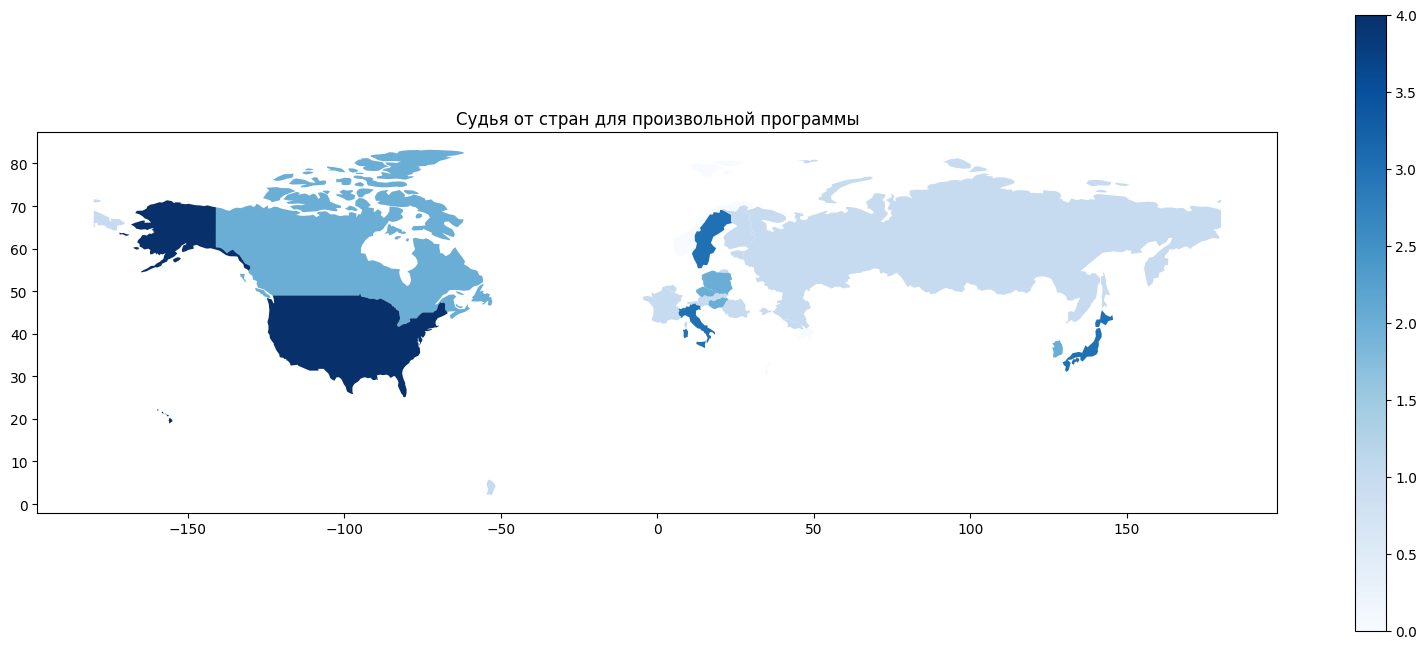

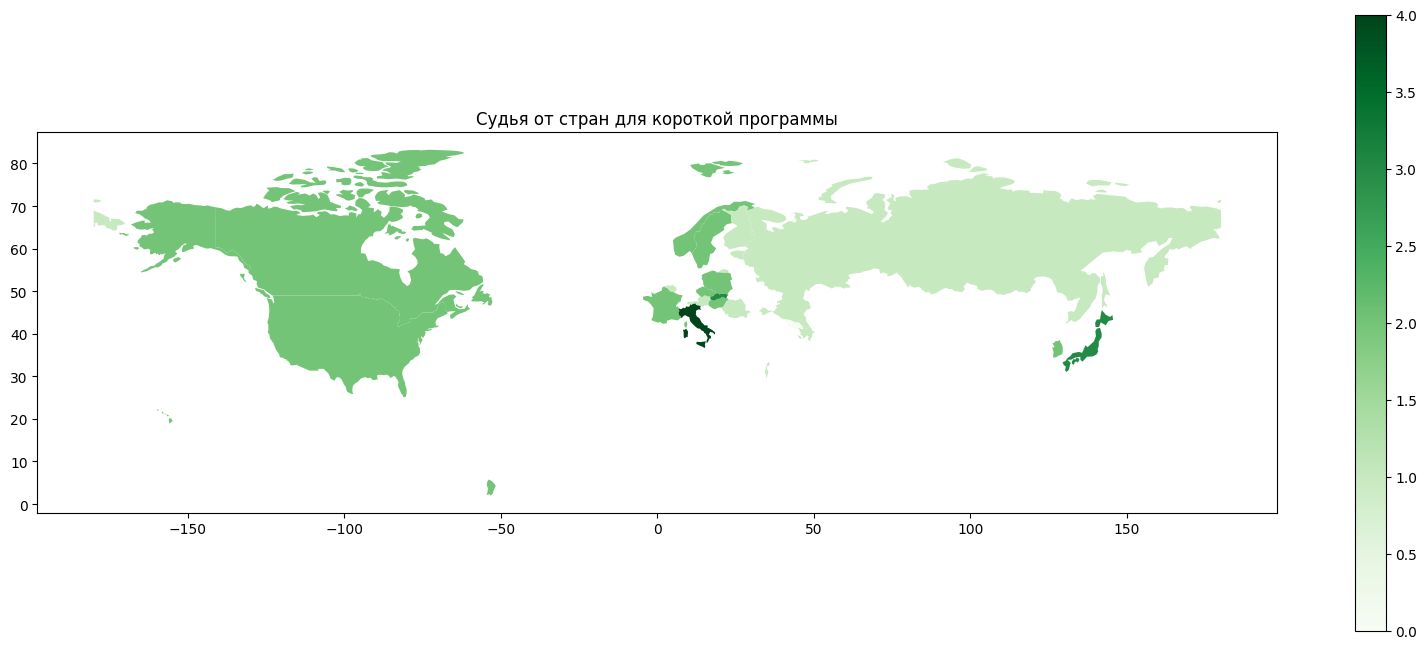

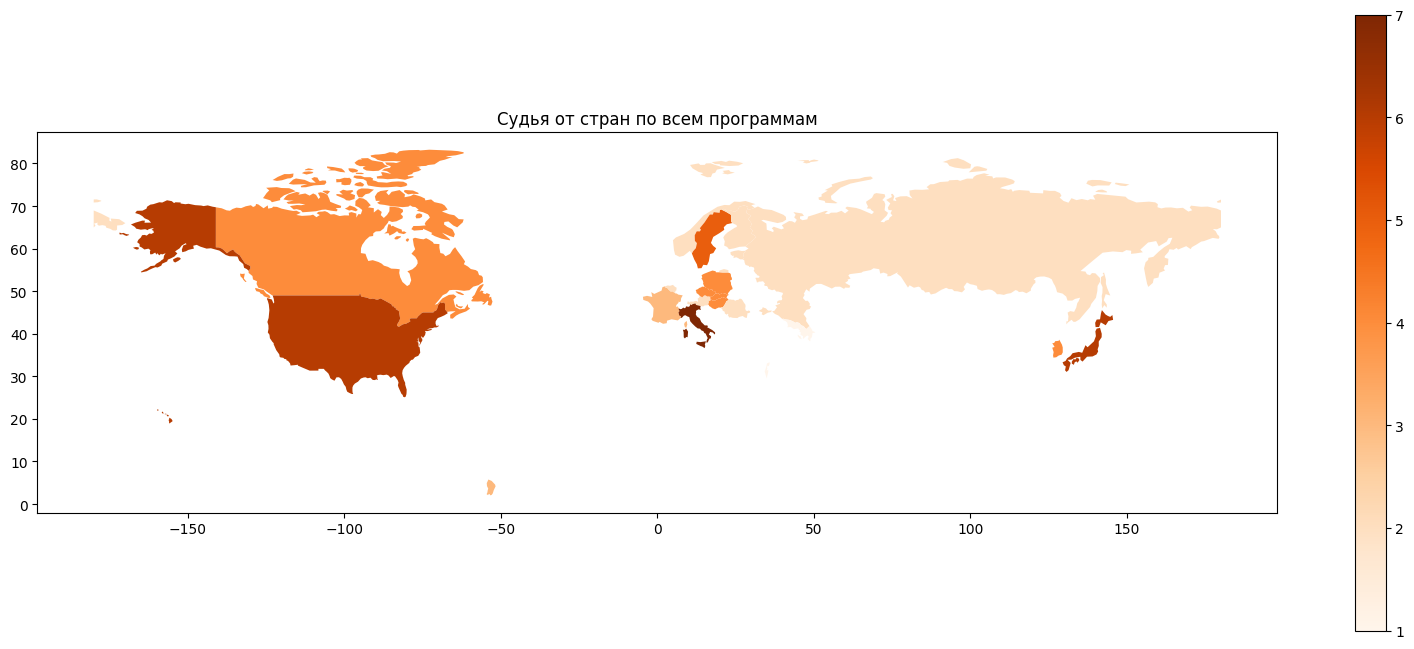

In [269]:
## Сделаем пробную визуализацию
fig, ax = plt.subplots(figsize=(20, 8))
colour.plot(column='count_long', cmap='Blues', ax=ax, legend=True)
plt.title("Судья от стран для произвольной программы")
plt.show()

fig, ax = plt.subplots(figsize=(20, 8))
colour.plot(column='count_short', cmap='Greens', ax=ax, legend=True)
plt.title("Судья от стран для короткой программы")
plt.show()

fig, ax = plt.subplots(figsize=(20, 8))
colour.plot(column='count_all', cmap='Oranges', ax=ax, legend=True)
plt.title("Судья от стран по всем программам")
plt.show()

In [277]:
df_final['ISR']>df_final['Total']

0       True
1      False
2       True
3       True
4       True
       ...  
304    False
305    False
306    False
307    False
308    False
Length: 309, dtype: bool

## Статистика по оценкам

In [ ]:
df_final['']

,Name,Country,Total,ISR,SVK,CZE,FRA,NOR,SUI,JPN,ITA,ROU,season,program,SWE,BEL,USA,POL,BUL,HUN,LAT,CAN,FIN,KOR,AUT,TPE,NED,AZE,EST,GEO,SLO,RUS,HKG,DEN,season+program
0,Alysa LIU,USA,74.58,77.23,75.71,73.06,72.85,74.68,73.65,73.92,75.45,74.65,2425,short,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2425short
1,Mone CHIBA,JPN,73.44,72.79,73.43,71.87,74.15,74.57,75.04,71.86,75.10,74.04,2425,short,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2425short
2,Isabeau LEVITO,USA,73.33,74.18,75.19,73.28,68.65,70.59,75.11,74.12,74.73,71.42,2425,short,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2425short
3,Wakaba HIGUCHI,JPN,72.10,77.62,69.52,71.46,65.98,73.39,71.40,72.11,73.73,72.71,2425,short,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2425short
4,Kaori SAKAMOTO,JPN,71.03,72.33,68.51,69.59,69.94,71.47,71.76,71.47,71.44,70.87,2425,short,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2425short
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,Alina URUSHADZE,GEO,109.12,NaN,111.06,110.83,NaN,NaN,NaN,NaN,NaN,NaN,2021,long,113.40,NaN,106.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.30,NaN,NaN,NaN,104.56,113.01,110.73,106.47,2021long
304,Hongyi CHEN,CHN,103.98,NaN,103.09,103.84,NaN,NaN,NaN,NaN,NaN,NaN,2021,long,95.72,NaN,101.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.93,NaN,NaN,NaN,104.28,106.72,107.23,103.26,2021long
305,Eliska BREZINOVA,CZE,96.33,NaN,99.99,97.64,NaN,NaN,NaN,NaN,NaN,NaN,2021,long,91.13,NaN,89.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.98,NaN,NaN,NaN,96.65,99.77,92.22,98.26,2021long
307,Natasha McKAY,GBR,95.31,NaN,96.19,97.67,NaN,NaN,NaN,NaN,NaN,NaN,2021,long,91.12,NaN,94.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.52,NaN,NaN,NaN,98.07,96.14,93.75,93.33,2021long


## Идеи для дальнейшего анализа

In [ ]:
# Элементы подробно

# ## Третья - оценки за элементы по технике
# df_3 = pd.read_html(str(tables[2]))[0]

# pd.read_html(str(tables[9]))[0]